In [ ]:
!git clone https://github.com/prajnasb/observations

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 11.54 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
!ls observations/experiements/dest_folder/

test  test.csv	train  train.csv  val


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy
import cv2
from PIL import Image

In [ ]:
experiments_path = '/content/observations/experiements/dest_folder'
data_path = '/content/observations/experiements/data'

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
def get_train_files_path(experiments_path, data_path, phase):
    if phase == 'train':
        file_name = 'train.csv'
    elif phase == 'test':
        file_name = 'test.csv'
    else:
        print("phase can only have train and test as parameter values")
        exit()
    file_path = os.path.join(experiments_path, file_name)
    train_df = pd.read_csv(file_path, delimiter=',')
    files_path = []
    fonts_class = []
    for row in train_df.iterrows():
        files_path.append(os.path.join(data_path, row[1]['class'], row[1]['filename']))
        fonts_class.append(row[1]['class'])
    
    return files_path, fonts_class

In [ ]:
def copy_images_to_path(file_path, file_class, destination_dir):
    font_folder = os.path.join(destination_dir, file_class)
    if os.path.exists(font_folder) == False:
        os.makedirs(font_folder)
    
    print("File being copied from {}:{}".format(file_path, font_folder))
    shutil.copy(file_path, font_folder)

In [ ]:
X_train, y_train = get_train_files_path(experiments_path, data_path, phase='train')
X_test, y_test = get_train_files_path(experiments_path, data_path, phase='test')

In [ ]:
train_dir = os.path.join(experiments_path, 'train')
test_dir = os.path.join(experiments_path, 'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [ ]:
for file_path, font_class in zip(X_train, y_train):
    copy_images_to_path(file_path, font_class, train_dir)

File being copied from /content/observations/experiements/data/with_mask/0-with-mask.jpg:/content/observations/experiements/dest_folder/train/with_mask
File being copied from /content/observations/experiements/data/with_mask/10-with-mask.jpg:/content/observations/experiements/dest_folder/train/with_mask
File being copied from /content/observations/experiements/data/with_mask/100-with-mask.jpg:/content/observations/experiements/dest_folder/train/with_mask
File being copied from /content/observations/experiements/data/with_mask/101-with-mask.jpg:/content/observations/experiements/dest_folder/train/with_mask
File being copied from /content/observations/experiements/data/with_mask/103-with-mask.jpg:/content/observations/experiements/dest_folder/train/with_mask
File being copied from /content/observations/experiements/data/with_mask/104-with-mask.jpg:/content/observations/experiements/dest_folder/train/with_mask
File being copied from /content/observations/experiements/data/with_mask/105-wi

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) for x in ['train', 'test']}

In [ ]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 1315
    Root location: /content/observations/experiements/dest_folder/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 194
    Root location: /content/observations/experiements/dest_folder/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=16, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f2f888816d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f2f888818d0>}

In [ ]:
class_names = image_datasets['train'].classes

In [ ]:
class_names

['with_mask', 'without_mask']

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

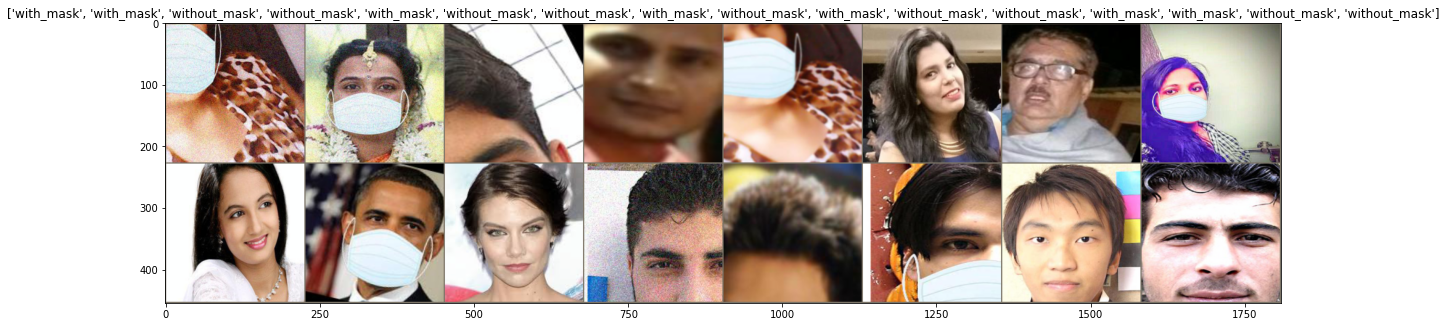

In [ ]:
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model

In [ ]:
import ssl

In [ ]:
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2381 Acc:0.9080

test Loss: 0.0025 Acc:1.0000

Epoch 1/19
----------
train Loss: 0.0993 Acc:0.9567

test Loss: 0.0007 Acc:1.0000

Epoch 2/19
----------
train Loss: 0.0858 Acc:0.9597

test Loss: 0.0006 Acc:1.0000

Epoch 3/19
----------
train Loss: 0.0800 Acc:0.9635

test Loss: 0.0350 Acc:1.0000

Epoch 4/19
----------
train Loss: 0.0684 Acc:0.9620

test Loss: 0.0289 Acc:0.9948

Epoch 5/19
----------
train Loss: 0.0618 Acc:0.9757

test Loss: 0.0005 Acc:1.0000

Epoch 6/19
----------
train Loss: 0.0704 Acc:0.9627

test Loss: 0.0004 Acc:1.0000

Epoch 7/19
----------
train Loss: 0.0722 Acc:0.9650

test Loss: 0.0014 Acc:1.0000

Epoch 8/19
----------
train Loss: 0.0788 Acc:0.9658

test Loss: 0.0004 Acc:1.0000

Epoch 9/19
----------
train Loss: 0.0703 Acc:0.9650

test Loss: 0.0003 Acc:1.0000

Epoch 10/19
----------
train Loss: 0.0673 Acc:0.9612

test Loss: 0.0005 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.0608 Acc:0.9673

test Loss: 0.0003 Acc:1.0000

Epoch 12/19
----------
t

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cd /content/gdrive/

In [ ]:
!ls

drive  gdrive  sample_data


In [ ]:
torch.save(model_ft, '/content/gdrive/My Drive/mask_detection_model_resnet101.pth')

In [3]:
filepath = '/content/gdrive/My Drive/mask_detection_model_resnet101.pth'
maskNet = torch.load(filepath)

In [4]:
class_names = ['with_mask',
 'without_mask'
]

In [5]:
def process_image(image):
    
    pil_image = image
   
    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img = image_transforms(pil_image)
    return img

In [6]:
def classify_face(image):
    device = torch.device("cpu")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #im_pil = image.fromarray(image)
    #image = np.asarray(im)
    im = Image.fromarray(image)
    image = process_image(im)
    print('image_processed')
    img = image.unsqueeze_(0)
    img = image.float()

    maskNet.eval()
    maskNet.cpu()
    output = maskNet(image)
    print(output,'##############output###########')
    out, predicted = torch.max(output, 1)
    print(predicted.data[0],"predicted")


    classification1 = predicted.data[0]
    index = int(classification1)
    print(class_names[index])
    return class_names[index]

In [7]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [8]:
def load_image(img_path):
	# image loading
	img = cv2.imread(img_path)
	img = cv2.resize(img, None, fx=0.4, fy=0.4)
	height, width, channels = img.shape
	return img, height, width, channels

In [9]:
def draw_labels(boxes, confs, colors, class_ids, classes, img):
  indexes = cv2.dnn.NMSBoxes(boxes, confs, 0.5, 0.4)
  font = cv2.FONT_HERSHEY_PLAIN
  for i in range(len(boxes)):
    if i in indexes:
      x, y, w, h = boxes[i]
      label = str(classes[class_ids[i]])
      color = colors[i]
      cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)
      cv2.putText(img, label, (x, y - 5), font, 1, color, 1)
  cv2_imshow(img)

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  f='/content/'
  imgpath=f+filename
  print('Saved to {}'.format(filename))
  #classify mask
  image, height, width, channels = load_image(imgpath)
  height, width, channels = image.shape
  blob, outputs = classify_face(image)
  boxes, confs, class_ids = get_box_dimensions(outputs, height, width)
  draw_labels(boxes, confs, colors, class_ids, classes, image)
  while True:
    key = cv2.waitKey(1)
    if key==27:
      break
  filename.release()
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg
type object 'Image' has no attribute 'fromarray'


In [19]:
from google.colab.patches import cv2_imshow
def draw_labels(boxes, confs, colors, class_ids, classes, img):
  indexes = cv2.dnn.NMSBoxes(boxes, confs, 0.5, 0.4)
  font = cv2.FONT_HERSHEY_PLAIN
  for i in range(len(boxes)):
    if i in indexes:
      x, y, w, h = boxes[i]
      label = str(classes[class_ids[i]])
      color = colors[i]
      cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)
      cv2.putText(img, label, (x, y - 5), font, 1, color, 1)
  cv2_imshow(img)

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html

In [10]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [11]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [12]:
def get_box_dimensions(outputs, height, width):
	boxes = []
	confs = []
	class_ids = []
	for output in outputs:
		for detect in output:
			scores = detect[5:]
			print(scores)
			class_id = np.argmax(scores)
			conf = scores[class_id]
			if conf > 0.3:
				center_x = int(detect[0] * width)
				center_y = int(detect[1] * height)
				w = int(detect[2] * width)
				h = int(detect[3] * height)
				x = int(center_x - w/2)
				y = int(center_y - h / 2)
				boxes.append([x, y, w, h])
				confs.append(float(conf))
				class_ids.append(class_id)
	return boxes, confs, class_ids

In [21]:
Known_distance = 24.0
Known_width = 14.3

# Colors
GREEN = (0, 255, 0)
RED = (0, 0, 255)
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)

In [14]:
fonts = cv2.FONT_HERSHEY_COMPLEX

In [15]:
from imutils import paths
import numpy as np
import imutils

In [16]:
def find_marker(image):
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	gray = cv2.GaussianBlur(gray, (5, 5), 0)
	edged = cv2.Canny(gray, 35, 125)
	cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key = cv2.contourArea)
	return cv2.minAreaRect(c)

In [17]:
def distance_to_camera(knownWidth, focalLength, perWidth):
	# compute and return the distance from the maker to the camera
	return (knownWidth * focalLength) / perWidth

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
colors = np.random.uniform(0, 255, size=(2, 3))
font = cv2.FONT_HERSHEY_COMPLEX_SMALL
score=0
thicc=2
while True:
    js_reply = video_frame(label_html, bbox)
    data = video_stream()
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    #image = cv2.imread(img)
    #model, classes, colors, output_layers = load_yolo2()
    while True:
      #_, frame = img.read()
      height, width, channels = img.shape
      outputs = classify_face(img)
      marker = find_marker(img)
      focalLength = (marker[1][0] * Known_distance) / Known_width
      inches = distance_to_camera(Known_width, focalLength, marker[1][0])
      # draw a bounding box around the image and display it
      box = cv2.cv.BoxPoints(marker) if imutils.is_cv2() else cv2.boxPoints(marker)
      box = np.int0(box)
      #cv2.drawContours(img, [box], -1, (0, 255, 0), 2)
      cv2.putText(img, "%.2fft" % (inches / 12),
        (img.shape[1] - 200, img.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX,
        2.0, (0, 255, 0), 3)
      cv2.putText(img,str(outputs),(100,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
      #label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if outputs == "Mask" else (0, 0, 255)
      #label = "{}: {:.2f}%".format(outputs, max(outputs) * 100)
      #draw_labels(boxes, confs, colors, class_ids, classes, img)
      cv2_imshow(img)
    js_reply.release()